# AuralSent: Harmonizing Text and Sound for Sentiment Analysis

In [1]:
#!pip install SpeechRecognition
#!pip install librosa
#resolves ImportError: Numba needs NumPy 1.24 or less
#!pip install numba --upgrade


In [2]:
#keep things clean
import warnings
warnings.filterwarnings ('ignore')




# Basic operations and file handling
import os
import numpy as np

# Audio processing and feature extraction
import librosa

# Machine Learning and model training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm




2024-03-27 05:53:10.492878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data:

# RAVDESS Dataset Overview

## Dataset Description

The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset is a collection of audio-only files that are 16bit and 48kHz in .wav format. It includes a comprehensive set of speech and song audio and video files, totaling 24.8 GB, which are fully available on Zenodo. The construction and perceptual validation of the RAVDESS dataset are detailed in an Open Access paper published in PLoS ONE.

This dataset segment focuses on emotional speech audio, featuring 1440 files that result from 60 trials per actor across 24 professional actors (12 female and 12 male). These actors vocalize two lexically-matched statements in a neutral North American accent, across a range of emotions including calm, happy, sad, angry, fearful, surprise, and disgust, at two levels of emotional intensity (normal and strong), along with a neutral expression.

## File Naming Convention

Each file in the RAVDESS dataset has a unique filename that encodes detailed information about the audio clip. The filename structure is a 7-part numerical identifier, for example, `03-01-06-01-02-01-12.wav`, which defines the stimulus characteristics as follows:

- **Modality**: 
  - 01 = Full audio-visual
  - 02 = Video-only
  - 03 = Audio-only
- **Vocal Channel**: 
  - 01 = Speech
  - 02 = Song
- **Emotion**: 
  - 01 = Neutral
  - 02 = Calm
  - 03 = Happy
  - 04 = Sad
  - 05 = Angry
  - 06 = Fearful
  - 07 = Disgust
  - 08 = Surprised
- **Emotional Intensity**: 
  - 01 = Normal
  - 02 = Strong (Note: There is no 'strong' intensity for neutral emotion)
- **Statement**: 
  - 01 = "Kids are talking by the door"
  - 02 = "Dogs are sitting by the door"
- **Repetition**: 
  - 01 = 1st Repetition
  - 02 = 2nd Repetition
- **Actor**: 
  - 01 to 24 (Odd numbers for male actors, even numbers for female actors)

### Example

The filename `03-01-06-01-02-01-12.wav` breaks down as follows:

- Audio-only (03)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "Dogs are sitting by the door" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

For further exploration, the Kaggle Song Emotion dataset is also recommended.



https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/datae


http://star.informatik.rwth-aachen.de/Publications/CEUR-WS/Vol-2328/3_2_paper_17.pdf

#### Lets take a look at the data

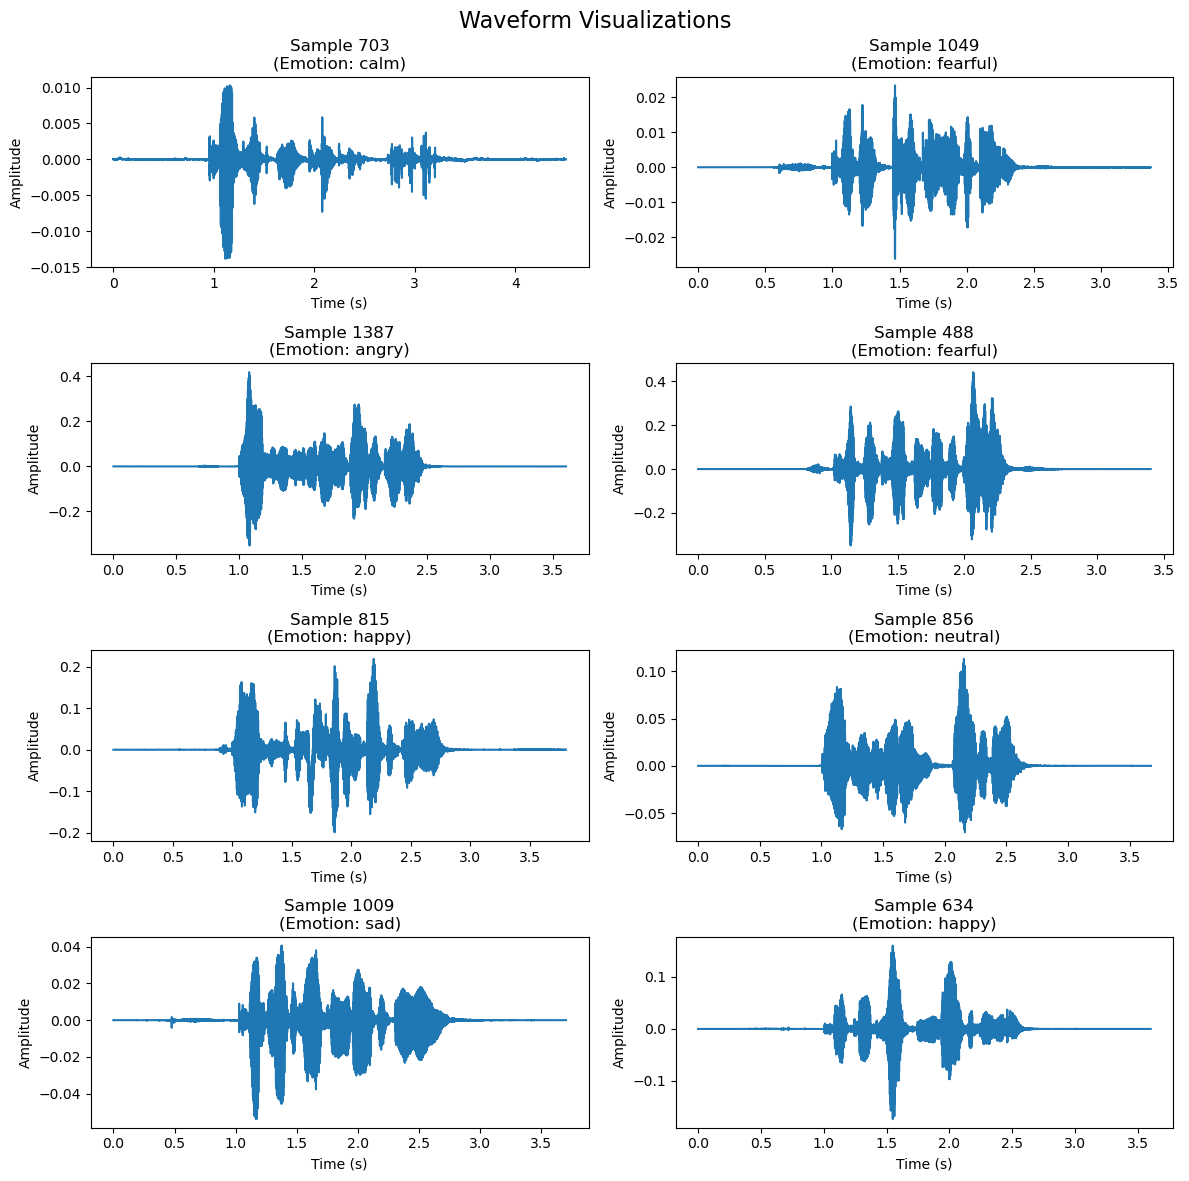

In [3]:
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

speech_data = []  # This will contain file paths
speech_labels = []  # This will contain corresponding labels
dataset_path = 'archive/'

actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
for actor_dir in actor_dirs:
    actor_path = os.path.join(dataset_path, actor_dir)
    filenames = os.listdir(actor_path)
    for filename in filenames:
        speech_data.append(os.path.join(actor_path, filename))
        # Assuming label is the third item in filename split by '-'
        speech_labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

#Random Sample Selection: Choose random samples from your dataset for visualization. 
sample_indices = np.random.choice(len(speech_data), size=8, replace=False)



num_rows = 4
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

fig.suptitle("Waveform Visualizations", fontsize=16)

for i, index in enumerate(sample_indices):
    row = i // num_cols
    col = i % num_cols

    audio_data, sr = librosa.load(speech_data[index])
    label_index = speech_labels[index]
    emotion = emotion_labels[label_index]

    duration = len(audio_data) / sr
    time = np.linspace(0, duration, num=len(audio_data))

    ax = axes[row, col]
    ax.plot(time, audio_data)
    ax.set_title(f"Sample {index+1}\n(Emotion: {emotion})")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


## Basic MFCCs data

##### (approx <2 min processing time)

In [4]:
def extract_features_and_labels(dataset_path):
    features, labels = [], []
    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Actors Progress"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            # Extract MFCCs
            y, sr = librosa.load(file_path, sr=None)  # 'sr=None' for the file's original sample rate
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            features.append(mfccs)
            # Extract emotion (3rd item in the filename split by '-')
            labels.append(int(filename.split('-')[2]) - 1)  # Subtract 1 to make labels start from 0
    return np.array(features), to_categorical(np.array(labels))


dataset_path = 'archive/'
features, labels = extract_features_and_labels(dataset_path)


Actors Progress: 100%|██████████████████████████| 24/24 [00:13<00:00,  1.72it/s]


### Advanced Fetaures

##### (approx 15 min processing time)

*   **Mel-Frequency Cepstral Coefficients (MFCCs)**: These coefficients are a representation of the short-term power spectrum of sound and are widely used in voice recognition and music information retrieval. They effectively capture the timbral aspects that are important for distinguishing between different emotional expressions.
    
*   **Chroma Features**: These features are based on the twelve different pitch classes and are useful for analyzing music and speech by summarizing information about harmonics and chords, which can vary significantly with emotional content.
    
*   **Mel-Spectrogram**: This represents the spectrum of frequencies of a sound signal as they vary with time. It's more sensitive to changes in emotional intensity than traditional spectrograms due to its emphasis on perceptually relevant frequencies.
    
*   **Spectral Contrast**: This feature captures the contrast in spectral peaks and valleys within the sound spectrum, reflecting the dynamic range of the audio signal which can be indicative of emotional intensity.
    
*   **Tonnetz**: Derived from the tonal centroid features, it captures harmonic relationships within audio signals and can provide insights into the emotional coloring of speech.
    
*   **Pitch**: The average pitch of the audio signal, which can vary with emotional states, such as higher pitches often associated with excited or anxious emotions.
    
*   **Magnitude**: Extracted alongside pitch through pitch tracking, representing the intensity of audio signals which can be an indicator of emotional strength.
    
*   **Tempo**: The overall tempo of the audio signal can also relate to the emotional content, with faster tempos potentially indicating higher levels of energy or agitation.

*   **Zero-Crossing Rate**: The rate at which the signal changes from positive to negative or back. This feature can be useful for distinguishing between different types of emotional expressions, as it relates to the textural characteristics of the sound.
    
*   **Energy**: The sum of squares of the signal, frame by frame, can indicate the loudness or intensity level of the speech, which is often correlated with emotional intensity.
    
*   **Entropy of Energy**: Measures the unpredictability of the energy in the audio signal, which could vary with different emotional states due to changes in the signal's dynamics.
    
*   **Formants**: The peak resonances in the vocal tract signal can provide information about the speaker's emotional state, as emotions can cause physiological changes that affect these resonances.



In [102]:
import librosa
import numpy as np
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical

def spectral_entropy(y, sr, n_fft=2048, hop_length=512):
    """
    Calculate the spectral entropy of an audio signal with Librosa.
    """
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
    S = librosa.power_to_db(D, ref=np.max)
    S_normalized = np.exp(S - np.max(S))
    S_normalized /= S_normalized.sum(axis=0)
    spectral_entropy = -np.sum(S_normalized * np.log2(S_normalized + 1e-8), axis=0)
    return np.mean(spectral_entropy)

def extract_comprehensive_features(file_path):
    """
    Extract an extended set of features including MFCCs, Chroma, Mel-Spectrogram,
    Spectral Contrast, Tonnetz, pitch, magnitude, tempo, Zero-Crossing Rate,
    Energy, and Spectral Entropy from an audio file.
    """
    y, sr = librosa.load(file_path, sr=None)

    # Basic audio features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    # Additional features: pitch, magnitude, and tempo
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch)
    mag_mean = np.mean(mag)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Zero-Crossing Rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y)[0])

    # Energy
    energy = np.sum(np.square(y)) / len(y)

    # Spectral Entropy
    entropy = spectral_entropy(y, sr)

    # Combine all features into a single array
    features = np.hstack([
        mfccs, chroma, mel, contrast, tonnetz, pitch_mean, mag_mean, tempo,
        zero_crossing_rate, energy, entropy
    ])
    
    return features

def extract_all_features_and_labels_with_additional(dataset_path):
    features = []
    labels = []

    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Processing Actors"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:
            file_path = os.path.join(actor_path, filename)
            audio_features = extract_comprehensive_features(file_path)
            features.append(audio_features)
            labels.append(int(filename.split('-')[2]) - 1)  # Adjust based on your dataset structure

    labels = np.array(labels)
    labels = to_categorical(labels)

    return np.array(features), labels

# Example usage
dataset_path = 'archive/'
features, labels = extract_all_features_and_labels_with_additional(dataset_path)


Processing Actors: 100%|████████████████████████| 24/24 [15:16<00:00, 38.19s/it]


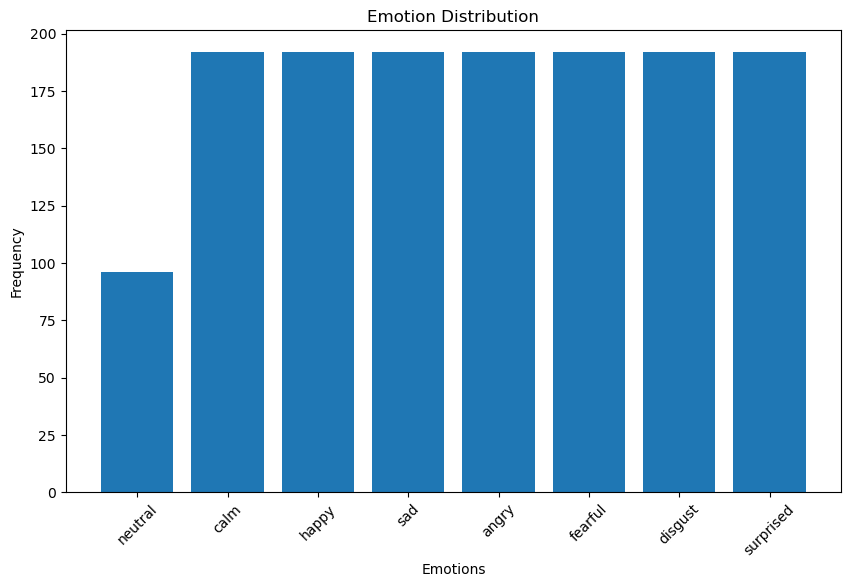

In [5]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each emotion
emotion_counts = {label: speech_labels.count(label) for label in set(speech_labels)}

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.title('Emotion Distribution')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(emotion_labels)), labels=emotion_labels, rotation=45)
plt.show()


Analyzing audio lengths: 100%|████████████| 1440/1440 [00:00<00:00, 2497.94it/s]


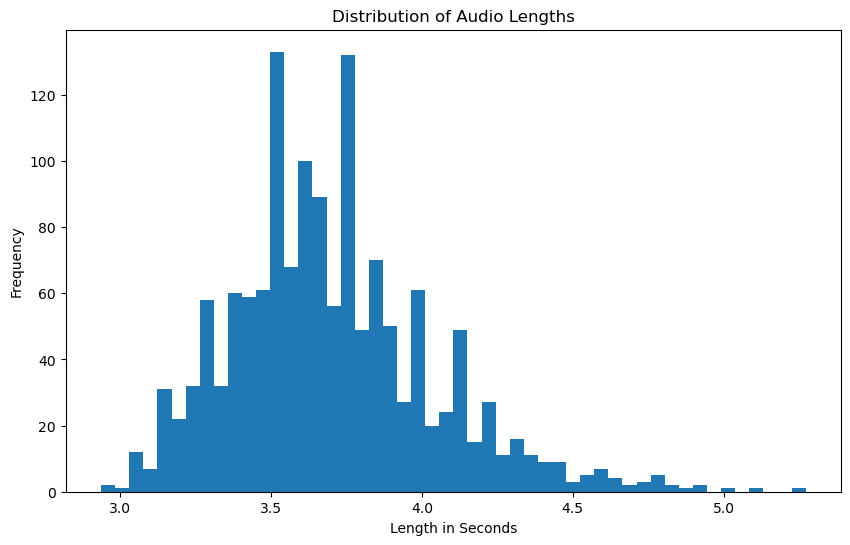

In [6]:
audio_lengths = []

for file_path in tqdm(speech_data, desc="Analyzing audio lengths"):
    y, sr = librosa.load(file_path, sr=None)
    audio_lengths.append(len(y) / sr)  # Length in seconds

# Plot the distribution of audio lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=50)
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length in Seconds')
plt.ylabel('Frequency')
plt.show()

In [7]:
corrupted_files = []

for file_path in tqdm(speech_data, desc="Checking for corrupted files"):
    try:
        y, sr = librosa.load(file_path, sr=None)
    except Exception as e:
        corrupted_files.append(file_path)

if corrupted_files:
    print(f"Found {len(corrupted_files)} corrupted files.")
else:
    print("No corrupted files found.")

Checking for corrupted files: 100%|███████| 1440/1440 [00:00<00:00, 2846.60it/s]

No corrupted files found.


## prep data for ML 

### Data Preparation and Feature Scaling

*   **Splitting Strategy**: Your use of a 60/20/20 split for training, validation, and test sets is a well-balanced choice, ensuring that the model is evaluated on a diverse sample of unseen data. It's crucial for gauging the model's generalization capabilities.
    
*   **Feature Scaling**: The application of `StandardScaler` is a prudent step for normalizing features, especially given the range and nature of audio features. This standardization likely contributes significantly to model performance by easing the learning process.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)

# Further split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler().fit(X_train)  # Fit on the training data
X_train = scaler.transform(X_train)  # Transform training data
X_val = scaler.transform(X_val)  # Transform validation data
X_test = scaler.transform(X_test)  # Transform test data

# Reshape features for Conv1D input (adding a channel dimension)
# Note: This step is specific to Conv1D; for RNN-based models, you might skip this reshaping.
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (864, 40, 1)
y_train shape: (864, 8)
X_val shape: (288, 40, 1)
y_val shape: (288, 8)
X_test shape: (288, 40, 1)
y_test shape: (288, 8)


### Custom noisey layer

In [83]:
class DynamicNoiseLayer(Layer):
    def __init__(self, noise_level=0.01, **kwargs):
        super(DynamicNoiseLayer, self).__init__(**kwargs)
        self.noise_level = noise_level

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.noise_level)
            return inputs + noise
        return inputs


### Basic CNN Model (Baseline)

This model will use 1D convolutional layers to extract features from the audio data

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Example definitions (you'll need to adjust these based on your actual dataset)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

model = Sequential([
    DynamicNoiseLayer(noise_level=0.3, input_shape=input_shape),
        Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dynamic_noise_layer_23 (Dy  (None, 40, 1)             0         
 namicNoiseLayer)                                                
                                                                 
 conv1d_46 (Conv1D)          (None, 38, 16)            64        
                                                                 
 max_pooling1d_46 (MaxPooli  (None, 19, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_47 (Conv1D)          (None, 17, 32)            1568      
                                                                 
 max_pooling1d_47 (MaxPooli  (None, 8, 32)             0         
 ng1D)                                                           
                                                     

### Define a Training Function
To streamline the process, we'll define a function that trains a model and evaluates its performance:

In [100]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min', restore_best_weights=True),
    ModelCheckpoint(f'cnn_best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='min'),
]
    
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=8,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=callbacks
    )

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/1000
108/108 [==============================] - 1s 5ms/step - loss: 2.0748 - accuracy: 0.1493 - val_loss: 2.0212 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 2/1000
108/108 [==============================] - 0s 4ms/step - loss: 2.0104 - accuracy: 0.1794 - val_loss: 1.9637 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 3/1000
108/108 [==============================] - 0s 4ms/step - loss: 1.9917 - accuracy: 0.2060 - val_loss: 1.9325 - val_accuracy: 0.2604 - lr: 0.0010
Epoch 4/1000
108/108 [==============================] - 0s 4ms/step - loss: 1.9511 - accuracy: 0.2350 - val_loss: 1.9044 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 5/1000
108/108 [==============================] - 0s 4ms/step - loss: 1.9272 - accuracy: 0.2569 - val_loss: 1.8696 - val_accuracy: 0.2882 - lr: 0.0010
Epoch 6/1000
108/108 [==============================] - 0s 4ms/step - loss: 1.8978 - accuracy: 0.2546 - val_loss: 1.8406 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 7/1000
108/108 [==============================] - 0s

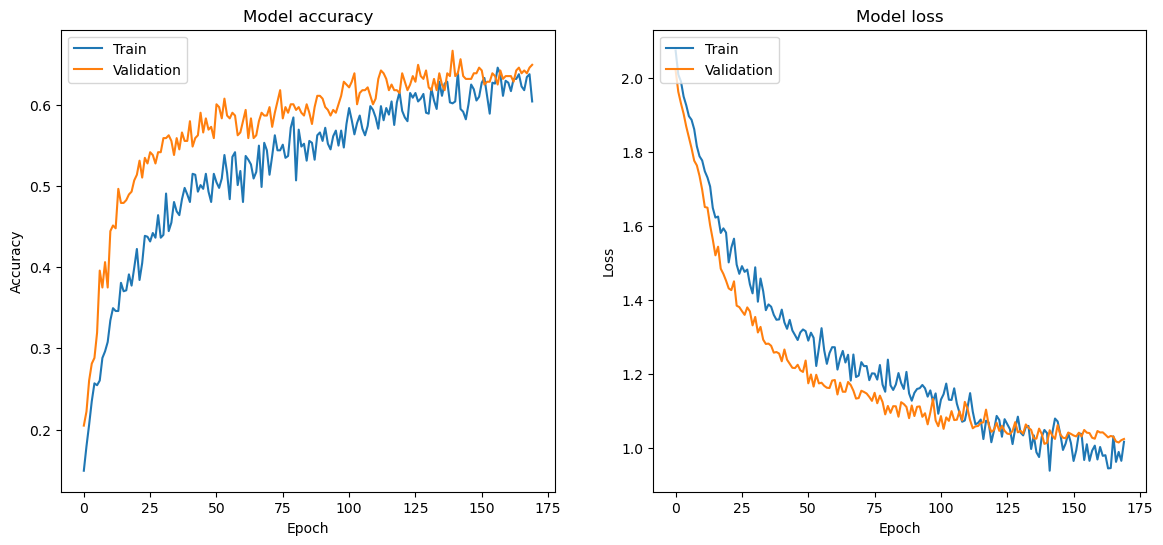

In [101]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()